In [1]:
# Load the packages
import math
import matplotlib.pyplot as plt
import seaborn as sns
import shap as shap
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings

# Libraries for missing values:
import missingno as msno   
# !pip install fancyimpute --target=/kaggle/working/
#import fancyimpute
warnings.filterwarnings("ignore")





In [2]:
# 2. Create interactive widgets in Jupyter notebooks
# Use Jupyter Widges Package - https://ipywidgets.readthedocs.io/en/stable/index.html 
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets
style = {'description_width': 'initial'}

# Configure pandas
pd.set_option('display.max_colwidth', None) # do not truncate column values
pd.set_option('display.max_rows', 200)      # max number of rows to display 
pd.set_option('display.max_columns', 300)   # max number of columns to display 

In [3]:
# Load the data
df_train = pd.read_csv("../datasets/train_new.csv", index_col='id')
df_test = pd.read_csv("../datasets/test_new.csv", index_col='id')

# get a list of categorical and numerical variables
categorical_features = list(df_train.select_dtypes(include=['object', 'category']).columns)
numerical_features = list(df_train.select_dtypes(include=['float64', 'int64']).columns)[:-1]

target_feature = 'price'

df_train.head()


,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,brand_category,top_brand,power_output,engine_size,cylinders,speed,transmission_type,ext_color_basic,int_color_basic
id,,,,,,,,,,,,,,,,,,,,,
0,Ford,F-150 Lariat,2018,74349,Gasoline,375.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,10-Speed A/T,Blue,Gray,None reported,Yes,11000,1,Ford,375.0,3.5,6.0,10.0,Automatic,blue,grey
1,BMW,335 i,2007,80000,Gasoline,300.0HP 3.0L Straight 6 Cylinder Engine Gasoline Fuel,6-Speed M/T,Black,Black,None reported,Yes,8250,3,BMW,300.0,3.0,6.0,6.0,Manual,black,black
2,Jaguar,XF Luxury,2009,91491,Gasoline,300.0HP 4.2L 8 Cylinder Engine Gasoline Fuel,6-Speed A/T,Purple,Beige,None reported,Yes,15000,3,other,300.0,4.2,8.0,6.0,Automatic,others,brown
3,BMW,X7 xDrive40i,2022,2437,Hybrid,335.0HP 3.0L Straight 6 Cylinder Engine Gasoline/Mild Electric Hybrid,Transmission w/Dual Shift Mode,Gray,Brown,None reported,Yes,63500,3,BMW,335.0,3.0,6.0,NaN,AM,grey,brown
4,Pontiac,Firebird Base,2001,111000,Gasoline,200.0HP 3.8L V6 Cylinder Engine Gasoline Fuel,A/T,White,Black,None reported,Yes,7850,1,other,200.0,3.8,6.0,NaN,Automatic,white,black


In [4]:
# print out the size of the data set
print("Shape of training set: ", df_train.shape)
print("Shape of testing set:", df_test.shape)

Shape of training set:  (54273, 21)
Shape of testing set: (36183, 20)


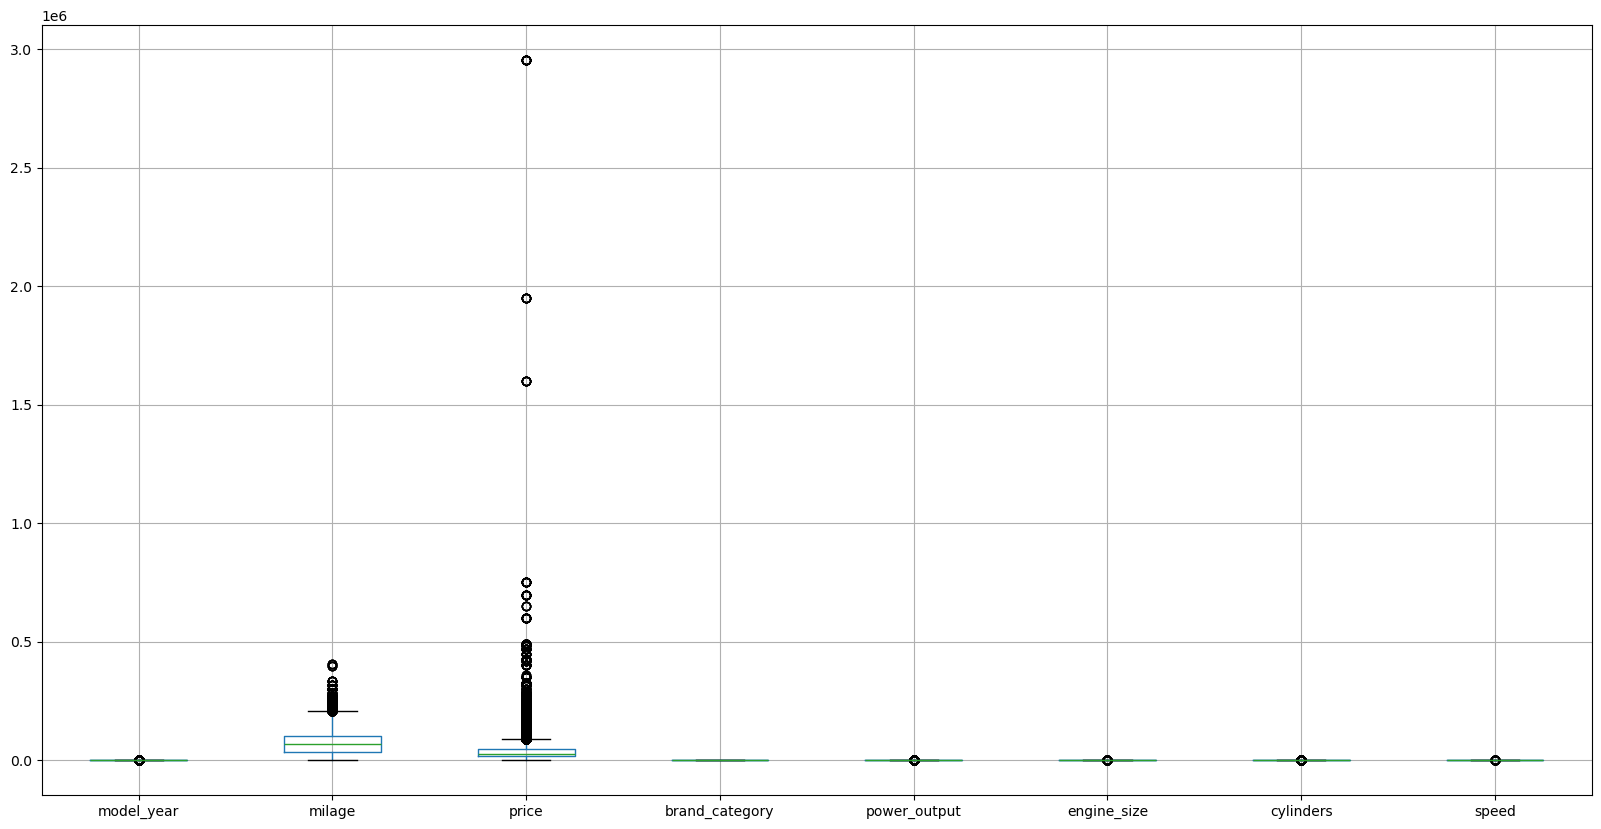

In [5]:
# identify outliers
df_train.boxplot(figsize=(20, 10))
plt.show()

In [6]:
# print out the size of the data set
print("Shape of training set: ", df_train.shape)
print("Shape of testing set:", df_test.shape)

Shape of training set:  (54273, 21)
Shape of testing set: (36183, 20)


While the z-score reduced the number of outliers we still saw outliers in prices where regular cars like Toyota which are supposed to be priced arounf 30K-40K recorded at 115K. 

In [7]:
np.set_printoptions(suppress=True)
# summary statistics of numeric features
# price = target feature
df_train.describe()

,model_year,milage,price,brand_category,power_output,engine_size,cylinders,speed
count,54273.000000,54273.000000,5.427300e+04,54273.000000,50216.000000,53667.000000,50098.000000,29409.000000
mean,2015.091979,72746.175667,3.921844e+04,1.985333,331.698323,3.716928,6.282347,7.107042
std,5.588909,50469.490448,7.282634e+04,0.944259,108.053342,1.336200,1.541834,1.505826
min,1974.000000,100.000000,2.000000e+03,1.000000,76.000000,0.650000,3.000000,1.000000
25%,2012.000000,32268.000000,1.550000e+04,1.000000,255.000000,3.000000,6.000000,6.000000
50%,2016.000000,66107.000000,2.800000e+04,2.000000,310.000000,3.500000,6.000000,7.000000
75%,2019.000000,102000.000000,4.500000e+04,3.000000,400.000000,4.600000,8.000000,8.000000
max,2024.000000,405000.000000,2.954083e+06,3.000000,1020.000000,8.400000,12.000000,10.000000


In [8]:
# model: too many unique values @ 1827
# engine: too many unique values -> can be broken down with NLP 
# transmission: can be broken down with NLP
# ext_col and int_col: too many values?

# clean_title: redundant feature since only one value present

df_train.describe(include=["object", "bool"])

,brand,model,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,top_brand,transmission_type,ext_color_basic,int_color_basic
count,54273,54273,54273,54273,54273,54273,54273,54273,54273,54273,54273,54273,54273
unique,53,1827,6,1061,46,260,124,2,1,14,5,8,8
top,BMW,F-150 XLT,Gasoline,300.0HP 3.0L Straight 6 Cylinder Engine Gasoline Fuel,A/T,Black,Black,None reported,Yes,other,Automatic,black,black
freq,7369,780,49439,1452,16757,15078,31820,39896,54273,12431,42184,15742,32734


In [9]:
df_test.describe(include=["object", "bool"])

,brand,model,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,top_brand,transmission_type,ext_color_basic,int_color_basic
count,36183,36183,36183,36183,36183,36183,36183,36183,36183,36183,36183,36183,36183
unique,53,1791,6,1038,44,230,111,2,1,14,5,8,8
top,BMW,F-150 XLT,Gasoline,300.0HP 3.0L Straight 6 Cylinder Engine Gasoline Fuel,A/T,Black,Black,None reported,Yes,other,Automatic,black,black
freq,4854,496,33033,886,11273,10027,21122,26598,36183,8261,28052,10443,21710


In [10]:
# check for duplicates
num_duplicates = df_train.duplicated().sum()

if num_duplicates !=0:
    print(f'There are {num_duplicates} duplicate rows, removing them from the data.')
    df_train.drop_duplicates(inplace=True)
else:
    print(f'{num_duplicates} duplicate rows detected.')

0 duplicate rows detected.


In [11]:
# check for missing values
def check_missing_values(df):
    missing_columns = [col for col in df.columns if df[col].isnull().any()]
    missingvalues_count =df.isna().sum()
    missingValues_df = pd.DataFrame(missingvalues_count.rename('Missing Values')).loc[missingvalues_count.ne(0)]
    missingValues_df['Percentage'] = missingValues_df['Missing Values'] * 100 / df.shape[0]
    return missingValues_df

df = check_missing_values(df_train)
print(df.sort_values(by='Missing Values', ascending=False))

              Missing Values  Percentage
speed                  24864   45.812835
cylinders               4175    7.692591
power_output            4057    7.475172
engine_size              606    1.116577


While we have lost of missing values in columns speed (45%), cylinder and power_output (7% each ) and engine_size (1%).  We have tried imputing these values based on the brand grouping but we could group the data by brand and model and merge back to the dataframe by brand and model. This allows us to reduce the numer of missing values significanly for each column. We can further update the missing values using the old techinue of imputation by applying the mean.

In [12]:
# "imputing" missing values based on brand and model grouping

# Combine df_train and df_test to calculate the average speed
combined_df = pd.concat([df_train, df_test])

# Group by 'brand' and 'model' and calculate the average values, ignoring NaN values
grouped_df = combined_df.groupby(['brand', 'model']).agg({
    'speed': 'mean',
    'cylinders': 'mean',
    'power_output': 'mean',
    'engine_size': 'mean'
}).reset_index()

# Define a function to merge and update values for the given columns
def update_columns(df, grouped_df, columns):
    df_merged = pd.merge(df, grouped_df, on=['brand', 'model'], left_index=True, suffixes=('', '_mean'))
    for col in columns:
        df_merged[col] = df_merged.apply(lambda row: row[f'{col}_mean'] if pd.isna(row[col]) else row[col], axis=1)
    return df_merged.drop(columns=[f'{col}_mean' for col in columns])

# List of columns to update
columns_to_update = ['speed', 'cylinders', 'power_output', 'engine_size']

# Update columns in both df_train and df_test
df_train = update_columns(df_train, grouped_df, columns_to_update)
df_test = update_columns(df_test, grouped_df, columns_to_update)


df = check_missing_values(df_train)
print(df.sort_values(by='Missing Values', ascending=False))

              Missing Values  Percentage
speed                    822    1.514565
cylinders                654    1.205019
power_output             470    0.865992
engine_size              230    0.423783


### Dropping columns 

modified columns: engine, transmission, ext_col, int_col, 

missing values: aspiration, valves, cylinder_layout, 

redundunt: clean_title , 



In [13]:
## drop columns
col_to_drop = [ 'engine', 'transmission', 'ext_col', 'int_col', 'brand',
               #'aspiration', 'valves', 'cylinder_layout', 
               'clean_title', 'model']

df_train.drop(columns=col_to_drop, axis=1, inplace=True)
df_test.drop(columns=col_to_drop, axis=1, inplace=True)

df_train.head()

,model_year,milage,fuel_type,accident,price,brand_category,top_brand,power_output,engine_size,cylinders,speed,transmission_type,ext_color_basic,int_color_basic
0,2018,74349,Gasoline,None reported,11000,1,Ford,375.0,3.5,6.0,10.000000,Automatic,blue,grey
1,2007,80000,Gasoline,None reported,8250,3,BMW,300.0,3.0,6.0,6.000000,Manual,black,black
2,2009,91491,Gasoline,None reported,15000,3,other,300.0,4.2,8.0,6.000000,Automatic,others,brown
3,2022,2437,Hybrid,None reported,63500,3,BMW,335.0,3.0,6.0,7.993506,AM,grey,brown
4,2001,111000,Gasoline,None reported,7850,1,other,200.0,3.8,6.0,4.181818,Automatic,white,black


In [14]:
# get a list of categorical and numerical variables
categorical_features = list(df_train.select_dtypes(include=['object', 'category']).columns)
numerical_features = list(df_train.select_dtypes(include=['float64', 'int64']).columns)
numerical_features.remove('price')
target_feature = 'price'


# print out the size of the data set
print("Shape of training set: ", df_train.shape)
print("Shape of testing set:", df_test.shape)

Shape of training set:  (54273, 14)
Shape of testing set: (36183, 13)


In [15]:
# Plotting the categorical variables in training and testing sets: ordered
# Define the function to plot the categorical variables
def count_plot(var, dataframe1, dataframe2):
    # Concatenate the two dataframes for the variable
    combined_data = pd.concat([dataframe1[var], dataframe2[var]]).dropna()
    
    # Determine the order of categories based on frequency
    category_order = combined_data.value_counts().index
    
    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6)) 
    
    # Plot training data
    sns.countplot(y=var, data=dataframe1, ax=axes[0], order=category_order)
    axes[0].set_title(f'Training Set - {var}')
    
    # Plot testing data
    sns.countplot(y=var, data=dataframe2, ax=axes[1], order=category_order)
    axes[1].set_title(f'Testing Set - {var}')
    
    plt.tight_layout()
    plt.show()

# Define a function for interactive plotting
def inter_cat_plot(x):
    return count_plot(x, df_train, df_test)


# Create a dropdown widget for selecting the categorical variable
widget_cat_plot = widgets.Dropdown(
    options=categorical_features,
    description="Categorical Variable:", 
    style=style
)

# Use interact to create an interactive plot
interact(inter_cat_plot, x=widget_cat_plot)

interactive(children=(Dropdown(description='Categorical Variable:', options=('fuel_type', 'accident', 'top_bra…

<function __main__.inter_cat_plot(x)>

In [19]:
# Plot numerical variables:

### Histogram plot function to display numerical features ###
def histogram_plot(var, dataframe1, dataframe2):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=True)  # Share both axes for comparison
    
    # Plot histogram for dataframe1 (training set)
    sns.histplot(dataframe1[var].dropna(), ax=axes[0], kde=True, element="step", color="skyblue", bins=10)
    axes[0].set_title(f'Training Set - {var}')
    
    # Plot histogram for dataframe2 (testing set)
    sns.histplot(dataframe2[var].dropna(), ax=axes[1], kde=True, element="step", color="orange", bins=10)
    axes[1].set_title(f'Testing Set - {var}')
    
    plt.tight_layout()
    plt.show()

def inter_num_plot(x):
    return histogram_plot(x, df_train, df_test)

### Multiple selection widgets for interactive plotting ###
widget_num_plot = widgets.Dropdown(
    options=numerical_features,
    description="Numerical Variable:", 
    style=style
)

interact(inter_num_plot, x=widget_num_plot)

interactive(children=(Dropdown(description='Numerical Variable:', options=('model_year', 'milage', 'brand_cate…

<function __main__.inter_num_plot(x)>

In [29]:
# Calculate correlation matrix 
# Check parameters: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html 
corr = df_train[numerical_features].corr() # method='pearson', 'kendall' , 'spearman'

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(9,6))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-0.8,vmax=0.8, square=True, linewidths=.5)

<Axes: >

## Feature engineering



### Missing values to deal with:

speed: 46%

cylinders: 37%

power output: 7%

engine_size: 1%


Can we get this information based on the {brand , model, model_year, fuel_type, transmission_type , power_output}. 



model: too many unique values @ 1827


In [22]:
# impute the missing values:

# Combine train and test datasets to ensure consistency in imputation
#df_combined = pd.concat([df_train, df_test], axis=0, ignore_index=True)

# Convert numeric columns to appropriate numeric types
columns_to_impute = ['speed', 'cylinders', 'power_output', 'engine_size']
#group_col = ['brand', 'model', 'transmission_type',  'model_year' ] #, 'fuel_type'

# Calculate the mean of columns_to_impute by grouping using group_col
#imputation_means = df_combined.groupby(group_col)[columns_to_impute].mean()

# Filling speed column with mean of Count column
#df_train.fillna(dataframe['speed'].mean(), inplace = True)

# Calculate mean for each column in df_train
impute_values = df_train[columns_to_impute].mean()


# Impute missing values in df_train
df_train_imputed  = df_train.fillna(impute_values, inplace=False)

# Impute missing values in df_test using the same impute_values
df_test_imputed = df_test.fillna(impute_values, inplace=False)

#df_train.groupby(group_col)['speed'].transform(lambda x: x.fillna(x.mean()))


In [25]:
# Plot numerical variables: imputed data

### Histogram plot function to display numerical features ###
def histogram_plot(var, dataframe1, dataframe2):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=True) # Share both axes for comparison
    sns.histplot(dataframe1[var].dropna(), ax=axes[0], kde=True, element="step", color="skyblue", bins=10)
    axes[0].set_title(f'Training Set - {var}')
    sns.histplot(dataframe2[var].dropna(), ax=axes[1], kde=True, element="step", color="orange", bins=10)
    axes[1].set_title(f'Testing Set - {var}')
    plt.tight_layout()
    plt.show()

def inter_num_plot(x):
    return histogram_plot(x, df_train_imputed, df_test_imputed)

### Multiple selection widgets for interactive plotting ###
widget_num_plot = widgets.Dropdown(
    options=numerical_features,
    description="Numerical Variable:", 
    style=style
)

interact(inter_num_plot, x=widget_num_plot)

interactive(children=(Dropdown(description='Numerical Variable:', options=('model_year', 'milage', 'brand_cate…

<function __main__.inter_num_plot(x)>

In [26]:

df = check_missing_values(df_test_imputed)
print(df.sort_values(by='Missing Values', ascending=False))

Empty DataFrame
Columns: [Missing Values, Percentage]
Index: []


In [27]:
df_train_imputed

,model_year,milage,fuel_type,accident,price,brand_category,top_brand,power_output,engine_size,cylinders,speed,transmission_type,ext_color_basic,int_color_basic
0,2018,74349,Gasoline,None reported,11000,1,Ford,375.000000,3.5,6.0,10.000000,Automatic,blue,grey
1,2007,80000,Gasoline,None reported,8250,3,BMW,300.000000,3.0,6.0,6.000000,Manual,black,black
2,2009,91491,Gasoline,None reported,15000,3,other,300.000000,4.2,8.0,6.000000,Automatic,others,brown
3,2022,2437,Hybrid,None reported,63500,3,BMW,335.000000,3.0,6.0,7.993506,AM,grey,brown
4,2001,111000,Gasoline,None reported,7850,1,other,200.000000,3.8,6.0,4.181818,Automatic,white,black
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54268,2017,29000,Gasoline,None reported,29000,3,BMW,445.000000,4.4,8.0,8.000000,Automatic,white,brown
54269,2015,94634,E85 Flex Fuel,At least 1 accident or damage reported,6500,3,Audi,220.000000,2.0,4.0,6.000000,Automatic,black,black
54270,2013,40989,Gasoline,At least 1 accident or damage reported,18950,3,Porsche,420.000000,3.6,6.0,7.746032,AM,white,black
54271,2023,1518,Gasoline,None reported,194965,3,Porsche,459.076923,4.0,6.0,8.000000,Automatic,brown,brown


In [33]:
# Spliting the dataset.
Y = np.log(df_train_imputed[target_feature]) # transform the price to log(price)
X = df_train_imputed.drop(columns=[target_feature])

X_train, X_val,y_train,y_val = train_test_split(X, Y, test_size=0.20, random_state=5)

Cat: ['brand',
 'fuel_type',
 'accident',
 'brand_category',
 'transmission_type',
 'ext_color_basic',
 'int_color_basic']


 Num: ['model_year', 'milage', 'power_output', 'engine_size', 'cylinders']

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error


one_hot_features = ['top_brand', 'fuel_type','transmission_type', 'ext_color_basic','int_color_basic' ,
                    'brand_category'] 
#label_encode_features = ['brand_category'] 
dummy_encode_features = ['accident'] 

# Function for dummy encoding
def dummy_encode(df):
    return pd.get_dummies(df, drop_first=True)

# Define the preprocessing for each column type
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('onehot', OneHotEncoder(), one_hot_features),
        ('dummy', FunctionTransformer(dummy_encode, validate=False), dummy_encode_features)
    ],
    remainder='passthrough'
)
'''
# Label encode separately as it needs to fit on the entire column
for col in label_encode_features:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    X_val[col] = le.transform(X_val[col])
   # df_test_imputed[col] = le.transform(df_test_imputed[col])
'''

# Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Fit the model
pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred = pipeline.predict(X_val)
r2 = r2_score(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

print(f'R-squared: {r2}')
print(f'RMSE: {rmse}')

R-squared: 0.6118647090918097
RMSE: 0.5194948537186591


In [40]:
y_test_pred = pipeline.predict(df_test_imputed)
y_test_pred

y_hat_data = df_test_imputed.copy(deep = True)
y_hat_data['price_lm'] = np.exp( y_test_pred)

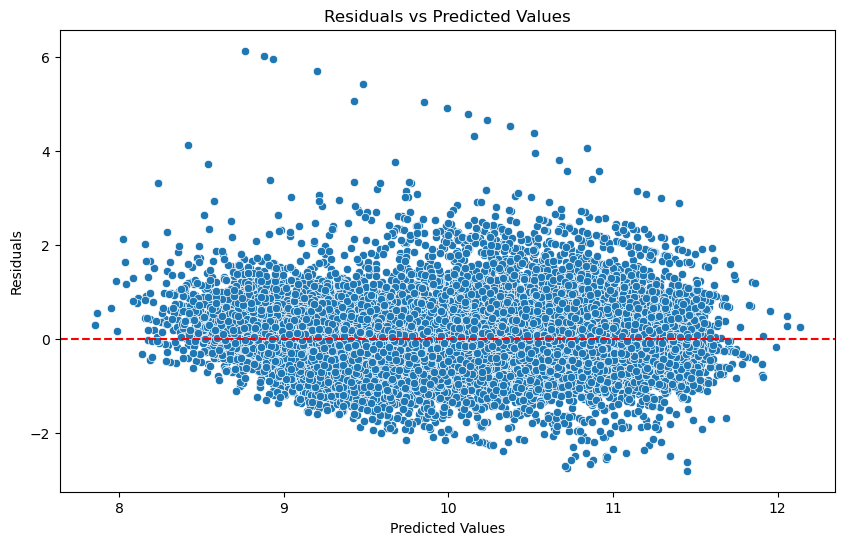

In [41]:
# residual analysis

import matplotlib.pyplot as plt
import seaborn as sns

# Predict on the training set to analyze residuals
y_train_pred = pipeline.predict(X_train)

# Residuals
residuals = y_train - y_train_pred

# Plot residuals
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_train_pred, y=residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.axhline(0, color='red', linestyle='--')
plt.show()


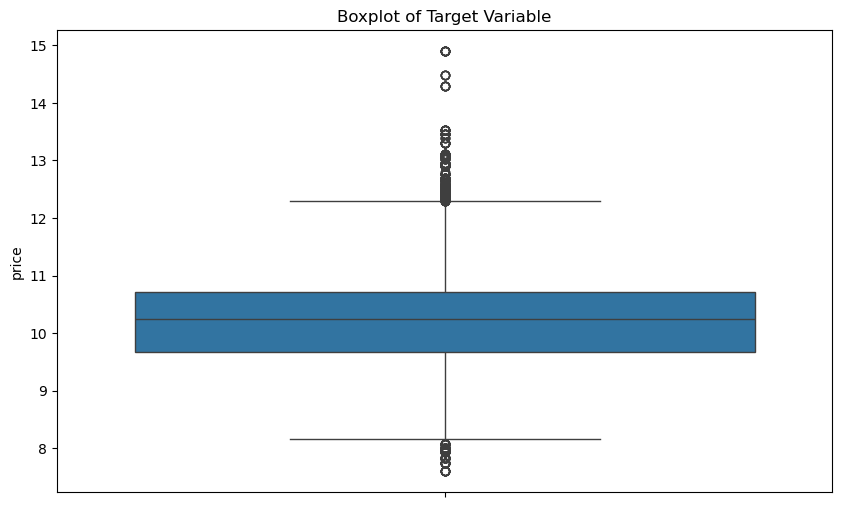

In [42]:
# outliers:
# Box plot to identify outliers in target variable
plt.figure(figsize=(10, 6))
sns.boxplot(y=y_train)
plt.title('Boxplot of Target Variable')
plt.show()


In [43]:
# model complexity

# Calculate training RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

# Print train and validation scores
print(f'Training RMSE: {train_rmse}')
print(f'Validation RMSE: {rmse}')
print(f'Training R-squared: {r2_score(y_train, y_train_pred)}')
print(f'Validation R-squared: {r2}')


Training RMSE: 0.5133177867253865
Validation RMSE: 0.5194948537186591
Training R-squared: 0.6132057869185837
Validation R-squared: 0.6118647090918097


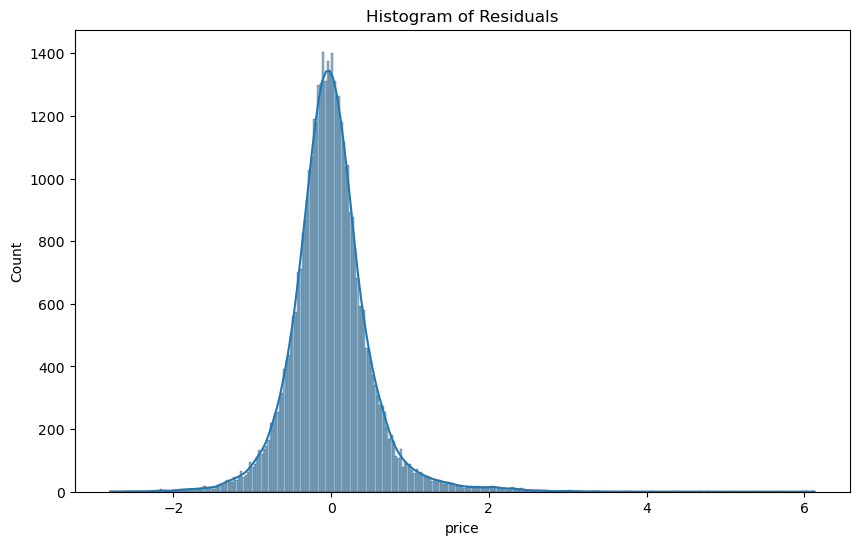

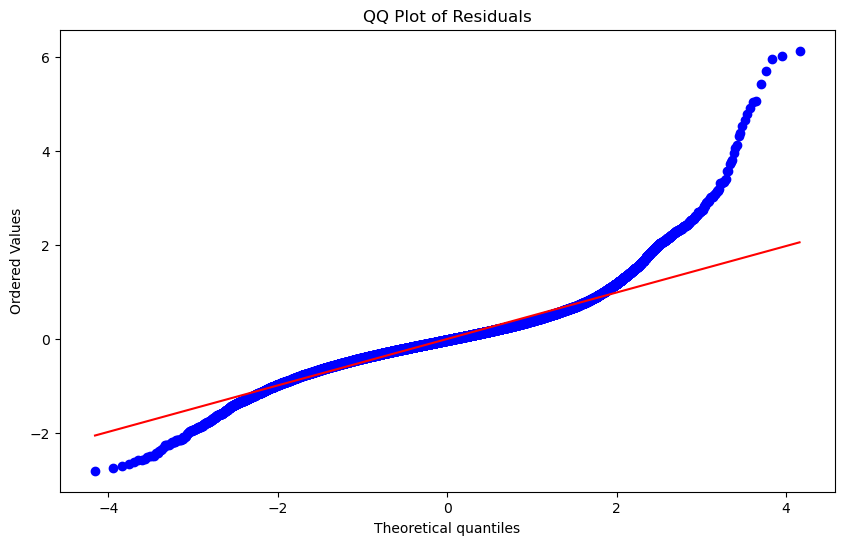

In [44]:
# Check normality of residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Histogram of Residuals')
plt.show()

# QQ plot
import scipy.stats as stats
plt.figure(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('QQ Plot of Residuals')
plt.show()


In [36]:
df_train_imputed

,model_year,milage,fuel_type,accident,price,brand_category,top_brand,power_output,engine_size,cylinders,speed,transmission_type,ext_color_basic,int_color_basic
id,,,,,,,,,,,,,,
0,2018,74349,Gasoline,None reported,11000,1,Ford,375.000000,3.5,6.000000,10.000000,Automatic,blue,grey
1,2007,80000,Gasoline,None reported,8250,3,BMW,300.000000,3.0,6.000000,6.000000,Manual,black,black
2,2009,91491,Gasoline,None reported,15000,3,other,300.000000,4.2,8.000000,6.000000,Automatic,others,brown
3,2022,2437,Hybrid,None reported,63500,3,BMW,335.000000,3.0,6.000000,7.107042,AM,grey,brown
4,2001,111000,Gasoline,None reported,7850,1,other,200.000000,3.8,6.000000,7.107042,Automatic,white,black
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54268,2017,29000,Gasoline,None reported,29000,3,BMW,445.000000,4.4,8.000000,8.000000,Automatic,white,brown
54269,2015,94634,E85 Flex Fuel,At least 1 accident or damage reported,6500,3,Audi,220.000000,2.0,4.000000,6.000000,Automatic,black,black
54270,2013,40989,Gasoline,At least 1 accident or damage reported,18950,3,Porsche,420.000000,3.6,6.000000,7.107042,AM,white,black


In [47]:
# Train and save multiple models
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
import joblib


models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, max_depth=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42),
    "Gradient Boost Regressor": GradientBoostingRegressor(random_state=42, learning_rate=0.05, loss="squared_error")
    #"SVR": SVR()
}

best_model = None
best_score = float('-inf')
best_model_name = ""

for name, model in models.items():
    model.fit(preprocessor.transform(X_train), y_train)
    y_pred = model.predict(preprocessor.transform(X_val))
    r2 = r2_score(y_val, y_pred)
    print(f"{name} R^2 score: {r2}")
    if r2 > best_score:
        best_score = r2
        best_model = model
        best_model_name = name

# Save the best model
joblib.dump(best_model, 'best_model.pkl')

print(f"Best model: {best_model_name} with R^2 score: {best_score}")


Linear Regression R^2 score: 0.6118647090918097
Random Forest R^2 score: 0.6287690139646893
XGBoost R^2 score: 0.645637482277399
Gradient Boost Regressor R^2 score: 0.6409866966375541
Best model: XGBoost with R^2 score: 0.645637482277399


## Hyperparameter Tuning

In [140]:
from sklearn.model_selection import RandomizedSearchCV

# Define the models and hyperparameter grids
models = {
    "Linear Regression": (LinearRegression(), {}),
    "Random Forest": (RandomForestRegressor(random_state=42), {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30, 40, 50]
    }),
    "XGBoost": (XGBRegressor(random_state=42), {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 4, 5, 6, 7],
        'learning_rate': [0.01, 0.1, 0.2, 0.3]
    })
    # SVR is too heavy for tuning...
}

best_model = None
best_score = float('-inf')
best_model_name = ""

for name, (model, param_grid) in models.items():
    if param_grid:
        search = RandomizedSearchCV(model, param_grid, n_iter=10, cv=5, scoring='r2', random_state=42, n_jobs=-1)
        search.fit(preprocessor.transform(X_train), y_train)
        best_model_for_name = search.best_estimator_
    else:
        best_model_for_name = model
        best_model_for_name.fit(preprocessor.transform(X_train), y_train)
    
    y_pred = best_model_for_name.predict(preprocessor.transform(X_val))
    r2 = r2_score(y_val, y_pred)
    print(f"{name} R^2 score: {r2}")
    if r2 > best_score:
        best_score = r2
        best_model = best_model_for_name
        best_model_name = name

# Save the best model and its name
joblib.dump(best_model, 'hypertuned_best_model.pkl')

print(f"Best model: {best_model_name} with R^2 score: {best_score}")



Linear Regression R^2 score: 0.6091838997337604
Random Forest R^2 score: 0.646582602587013
XGBoost R^2 score: 0.6481680302276254
Best model: XGBoost with R^2 score: 0.6481680302276254


In [142]:
# Load the test data, make predictions, and save the results
df_test_imputed_transformed = preprocessor.transform(df_test_imputed)
predictions = best_model.predict(df_test_imputed_transformed)
results = pd.DataFrame({
    'price': predictions
})

# Save results to a CSV file
#results.to_csv('../datasets/predictions.csv', index=False)
#print("Predictions saved to predictions.csv")

In [143]:
results
y_hat_data['price_xgb'] = np.exp(predictions)
y_hat_data
#df_train_imputed[df_train_imputed['brand']=='Saab']

,model_year,milage,fuel_type,accident,brand_category,top_brand,power_output,engine_size,cylinders,speed,transmission_type,ext_color_basic,int_color_basic,price_lm,price_xgb
id,,,,,,,,,,,,,,,
54273,2014,73000,Gasoline,None reported,3,Mercedes-Benz,302.0,3.5,6.0,7.088654,Automatic,white,brown,23721.674728,20367.732422
54274,2015,128032,Gasoline,None reported,3,Lexus,275.0,3.5,6.0,8.000000,Automatic,silver,black,18608.859969,19710.099609
54275,2015,51983,Gasoline,None reported,3,Mercedes-Benz,241.0,2.0,4.0,7.000000,Automatic,blue,white,25967.694625,24957.185547
54276,2018,29500,Gasoline,At least 1 accident or damage reported,2,Land,518.0,5.0,8.0,7.088654,AM,white,white,54198.750659,47292.171875
54277,2020,90000,Gasoline,At least 1 accident or damage reported,3,BMW,335.0,3.0,6.0,8.000000,Automatic,white,black,28288.161642,31658.546875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90451,2019,4500,Gasoline,None reported,1,GMC,420.0,6.2,8.0,10.000000,Automatic,grey,black,58376.844744,54554.929688
90452,2004,185000,Gasoline,At least 1 accident or damage reported,1,Chevrolet,295.0,5.3,8.0,4.000000,Automatic,red,grey,6339.108564,7370.627930
90453,2011,116000,Gasoline,None reported,1,Toyota,132.0,1.8,4.0,5.000000,Manual,brown,grey,11607.073940,8617.523438


In [144]:
# add 'ensemble'
y_hat_data['price_mix'] = (y_hat_data['price_lm'] + y_hat_data['price_xgb'])/2
y_hat_data

,model_year,milage,fuel_type,accident,brand_category,top_brand,power_output,engine_size,cylinders,speed,transmission_type,ext_color_basic,int_color_basic,price_lm,price_xgb,price_mix
id,,,,,,,,,,,,,,,,
54273,2014,73000,Gasoline,None reported,3,Mercedes-Benz,302.0,3.5,6.0,7.088654,Automatic,white,brown,23721.674728,20367.732422,22044.703575
54274,2015,128032,Gasoline,None reported,3,Lexus,275.0,3.5,6.0,8.000000,Automatic,silver,black,18608.859969,19710.099609,19159.479789
54275,2015,51983,Gasoline,None reported,3,Mercedes-Benz,241.0,2.0,4.0,7.000000,Automatic,blue,white,25967.694625,24957.185547,25462.440086
54276,2018,29500,Gasoline,At least 1 accident or damage reported,2,Land,518.0,5.0,8.0,7.088654,AM,white,white,54198.750659,47292.171875,50745.461267
54277,2020,90000,Gasoline,At least 1 accident or damage reported,3,BMW,335.0,3.0,6.0,8.000000,Automatic,white,black,28288.161642,31658.546875,29973.354259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90451,2019,4500,Gasoline,None reported,1,GMC,420.0,6.2,8.0,10.000000,Automatic,grey,black,58376.844744,54554.929688,56465.887216
90452,2004,185000,Gasoline,At least 1 accident or damage reported,1,Chevrolet,295.0,5.3,8.0,4.000000,Automatic,red,grey,6339.108564,7370.627930,6854.868247
90453,2011,116000,Gasoline,None reported,1,Toyota,132.0,1.8,4.0,5.000000,Manual,brown,grey,11607.073940,8617.523438,10112.298689


In [145]:
# saving the predictions to csv
y_hat_data['price_lm'].to_csv('../datasets/predictions_lm_2.csv')
y_hat_data['price_xgb'].to_csv('../datasets/predictions_xgb_2.csv')
y_hat_data['price_mix'].to_csv('../datasets/predictions_mix_2.csv')
print("Predictions saved to predictions.csv")

Predictions saved to predictions.csv


Sources:

https://www.kaggle.com/competitions/kagglex-cohort4/overview

https://www.kaggle.com/code/saadatkhalid/laptop-price-prediction-eda-model-app

